In [165]:
!pip install pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendar_utils import register_calendar, get_calendar


In [167]:
bundle_data = bundles.load('quandl')

In [168]:
end_date = pd.Timestamp('2019-01-01', tz = "UTC")

In [169]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00')

In [170]:
type(bundle_data)

zipline.data.bundles.core.BundleData

In [171]:
bundle_data

BundleData(asset_finder=<zipline.assets.assets.AssetFinder object at 0x0000025CFD7E27F0>, equity_minute_bar_reader=<zipline.data.bcolz_minute_bars.BcolzMinuteBarReader object at 0x0000025CFD7522E0>, equity_daily_bar_reader=<zipline.data.bcolz_daily_bars.BcolzDailyBarReader object at 0x0000025CFD7E2490>, adjustment_reader=<zipline.data.adjustments.SQLiteAdjustmentReader object at 0x0000025CFDBDAA00>)

In [172]:
# Set the daily frequency
data_por = DataPortal(
    asset_finder = bundle_data.asset_finder,
    trading_calendar = get_calendar("NYSE"),
    first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader = bundle_data.equity_daily_bar_reader
)

In [173]:
TSLA = data_por.asset_finder.lookup_symbol(
    "TSLA",
    as_of_date = None
)

In [174]:
df = data_por.get_history_window(
    assets = [TSLA],
    end_dt = end_date,
    bar_count = 5000, #5000 trading days data is used
    frequency = '1d',
    data_frequency = 'daily',
    field = 'close'  # We will be using more of the close values to do prediction

)

In [175]:
df.head()

,Equity(2862 [TSLA])
1999-02-19,NaN
1999-02-22,NaN
1999-02-23,NaN
1999-02-24,NaN
1999-02-25,NaN


In [176]:
df.describe()

,Equity(2862 [TSLA])
count,1949.000000
mean,158.641131
std,111.041316
min,15.800000
25%,31.600000
50%,192.690000
75%,240.240000
max,385.000000


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 1999-02-19 to 2019-01-02
Freq: C
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Equity(2862 [TSLA])  1949 non-null   float64
dtypes: float64(1)
memory usage: 78.1 KB


In [178]:
# Let us drop the NaN values
df = df.dropna()

In [179]:
df.isna().sum()

Equity(2862 [TSLA])    0
dtype: int64

In [180]:
df.index = pd.DatetimeIndex(df.index)

In [181]:
df.head()

,Equity(2862 [TSLA])
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
2010-07-06,16.11


In [182]:
df.count

<bound method DataFrame.count of             Equity(2862 [TSLA])
2010-06-29                23.89
2010-06-30                23.83
2010-07-01                21.96
2010-07-02                19.20
2010-07-06                16.11
...                         ...
2018-03-21               316.53
2018-03-22               309.10
2018-03-23               301.54
2018-03-26               304.18
2018-03-27               279.18

[1949 rows x 1 columns]>

In [183]:
df.value_counts

<bound method DataFrame.value_counts of             Equity(2862 [TSLA])
2010-06-29                23.89
2010-06-30                23.83
2010-07-01                21.96
2010-07-02                19.20
2010-07-06                16.11
...                         ...
2018-03-21               316.53
2018-03-22               309.10
2018-03-23               301.54
2018-03-26               304.18
2018-03-27               279.18

[1949 rows x 1 columns]>

In [184]:
list[df.columns[0]]

list[Equity(2862 [TSLA])]

In [185]:
df['close'] = df[list[df.columns[0]]]

In [186]:
df.head()

,Equity(2862 [TSLA]),close
2010-06-29,23.89,23.89
2010-06-30,23.83,23.83
2010-07-01,21.96,21.96
2010-07-02,19.20,19.20
2010-07-06,16.11,16.11


In [187]:
df.drop(columns = [list(df.columns)[0]], inplace  = True, axis = 0)

In [188]:
df.head()

,close
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
2010-07-06,16.11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


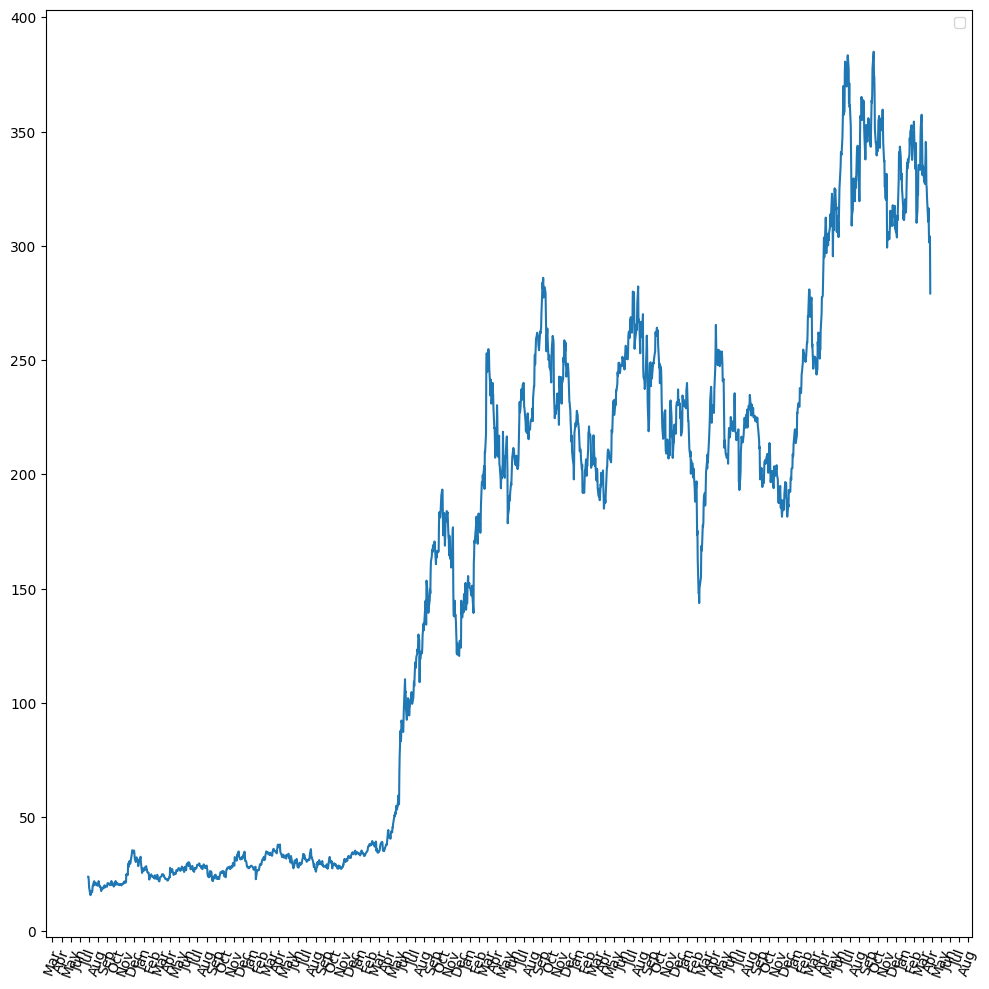

In [189]:
# Let us plot the data
from matplotlib.dates import MonthLocator, date2num, DateFormatter

fig, ax = plt.subplots()
fig.subplots_adjust(bottom = 0.3)

fig.set_figwidth(10)
fig.set_figheight(10)

ax.plot(df.index, df.close)

lctr = MonthLocator() # For eevry month
frmt = DateFormatter('%b')

ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

ax.legend()

plt.xticks(rotation = 70)
plt.tight_layout()
plt.show()

In [190]:
df['1d'] = df.shift(-1)  # We copy the values of the next row into the current one

In [191]:
df.head()

,close,1d
2010-06-29,23.89,23.83
2010-06-30,23.83,21.96
2010-07-01,21.96,19.20
2010-07-02,19.20,16.11
2010-07-06,16.11,15.80


In [192]:
df.tail()

,close,1d
2018-03-21,316.53,309.10
2018-03-22,309.10,301.54
2018-03-23,301.54,304.18
2018-03-26,304.18,279.18
2018-03-27,279.18,NaN


In [193]:
# We will construct the time-series data for 30 days and predict the data for 
# next 8 days. In addition to this, we will be doing this for the next
# two years.
for d in range(2, 41):

    col = '%dd' % d
    df[col] = df['close'].shift(-1 * d)


In [194]:
df.head()

,close,1d,2d,3d,4d,5d,6d,7d,8d,9d,...,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
2010-06-29,23.89,23.83,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,...,17.60,18.32,18.78,19.15,18.77,18.79,19.10,20.13,19.20,19.90
2010-06-30,23.83,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,...,18.32,18.78,19.15,18.77,18.79,19.10,20.13,19.20,19.90,19.75
2010-07-01,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,...,18.78,19.15,18.77,18.79,19.10,20.13,19.20,19.90,19.75,19.70
2010-07-02,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,20.64,...,19.15,18.77,18.79,19.10,20.13,19.20,19.90,19.75,19.70,19.87
2010-07-06,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,20.64,21.91,...,18.77,18.79,19.10,20.13,19.20,19.90,19.75,19.70,19.87,19.48


In [195]:
df.tail()

,close,1d,2d,3d,4d,5d,6d,7d,8d,9d,...,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
2018-03-21,316.53,309.10,301.54,304.18,279.18,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-22,309.10,301.54,304.18,279.18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-23,301.54,304.18,279.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-26,304.18,279.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-27,279.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
df = df.dropna()

In [204]:
# Let us slice the rows and the colms to be useed
# As the the X and y data-set
X = df.iloc[:, :33]
y = df.iloc[:, 33:]
X.head()

,close,1d,2d,3d,4d,5d,6d,7d,8d,9d,...,23d,24d,25d,26d,27d,28d,29d,30d,31d,32d
2010-06-29,23.89,23.83,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,...,20.92,21.95,21.26,20.45,19.59,19.60,19.03,17.90,17.60,18.32
2010-06-30,23.83,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,...,21.95,21.26,20.45,19.59,19.60,19.03,17.90,17.60,18.32,18.78
2010-07-01,21.96,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,...,21.26,20.45,19.59,19.60,19.03,17.90,17.60,18.32,18.78,19.15
2010-07-02,19.20,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,20.64,...,20.45,19.59,19.60,19.03,17.90,17.60,18.32,18.78,19.15,18.77
2010-07-06,16.11,15.80,17.46,17.40,17.05,18.14,19.84,19.89,20.64,21.91,...,19.59,19.60,19.03,17.90,17.60,18.32,18.78,19.15,18.77,18.79


In [205]:
y.head()

,33d,34d,35d,36d,37d,38d,39d,40d
2010-06-29,18.78,19.15,18.77,18.79,19.10,20.13,19.20,19.90
2010-06-30,19.15,18.77,18.79,19.10,20.13,19.20,19.90,19.75
2010-07-01,18.77,18.79,19.10,20.13,19.20,19.90,19.75,19.70
2010-07-02,18.79,19.10,20.13,19.20,19.90,19.75,19.70,19.87
2010-07-06,19.10,20.13,19.20,19.90,19.75,19.70,19.87,19.48


In [206]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [208]:
print("Shape of X_train is ", X_train.shape)
print("Shape of X_test is ", X_test.shape)
print("Shape of y_train is ", y_train.shape)
print("Shape of y_test is ", X_test.shape)

Shape of X_train is  (1145, 33)
Shape of X_test is  (764, 33)
Shape of y_train is  (1145, 8)
Shape of y_test is  (764, 33)


In [209]:
# Check for NaN values using isna()
nan_check = X_train.isna()

# Alternatively, you can use isnull() method
# nan_check = X_train.isnull()

# Summing the boolean values will give you the count of NaN values for each column
nan_counts = nan_check.sum()

# Print the counts of NaN values for each column
print(nan_counts)
any_nan = nan_check.any().any()

if any_nan:
    print("X_train has NaN values.")
else:
    print("X_train doesn't have NaN values.")


close    0
1d       0
2d       0
3d       0
4d       0
5d       0
6d       0
7d       0
8d       0
9d       0
10d      0
11d      0
12d      0
13d      0
14d      0
15d      0
16d      0
17d      0
18d      0
19d      0
20d      0
21d      0
22d      0
23d      0
24d      0
25d      0
26d      0
27d      0
28d      0
29d      0
30d      0
31d      0
32d      0
dtype: int64
X_train doesn't have NaN values.


In [210]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(
    n_estimators=100,
    criterion='friedman_mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='log2',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,  # Use min_impurity_decrease instead of min_impurity_split
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=None,
    verbose=1,
    warm_start=False
)

regressor.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(criterion='friedman_mse', max_features='log2', n_jobs=-1,
                      oob_score=True, verbose=1)

In [211]:
regressor.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9942708098730886

In [212]:
regressor.base_estimator_

e:\Python\envs\TradingProject\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


DecisionTreeRegressor()

In [213]:
regressor.feature_importances_

array([0.00054649, 0.00059931, 0.00078178, 0.00079623, 0.00103385,
       0.0177355 , 0.00133034, 0.0175252 , 0.02748495, 0.01797053,
       0.00957551, 0.01001581, 0.01686178, 0.00910782, 0.00877166,
       0.03321012, 0.00974332, 0.02744361, 0.02564244, 0.00452797,
       0.01266625, 0.0114143 , 0.00467597, 0.00405405, 0.02560811,
       0.03020409, 0.02289033, 0.05882087, 0.07861117, 0.12446494,
       0.10861879, 0.17246944, 0.10479744])

In [214]:
y_test.head()

,33d,34d,35d,36d,37d,38d,39d,40d
2014-05-14,239.72,229.425,229.250,222.66,219.070,223.06,219.46,218.13
2017-05-16,352.62,327.090,308.890,313.22,316.050,327.22,329.52,323.41
2017-06-20,355.17,365.220,363.525,355.13,357.715,363.80,362.33,362.91
2014-01-06,217.65,248.000,253.000,252.54,244.810,250.56,254.84,252.66
2010-10-22,32.05,31.520,30.550,28.53,29.600,30.81,31.36,31.70


In [215]:
y_test.tail()

,33d,34d,35d,36d,37d,38d,39d,40d
2015-10-02,221.07,221.80,220.01,217.75,218.25,229.64,231.61,230.26
2016-05-11,201.79,210.19,212.28,216.50,213.98,214.44,215.94,216.78
2013-04-18,95.37,97.35,102.04,100.05,94.47,97.73,98.18,100.30
2011-10-27,28.53,28.62,28.00,27.75,27.90,27.57,27.77,27.90
2011-08-04,25.85,25.63,26.38,25.52,26.19,24.59,24.12,24.39


In [216]:
y_pred = regressor.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


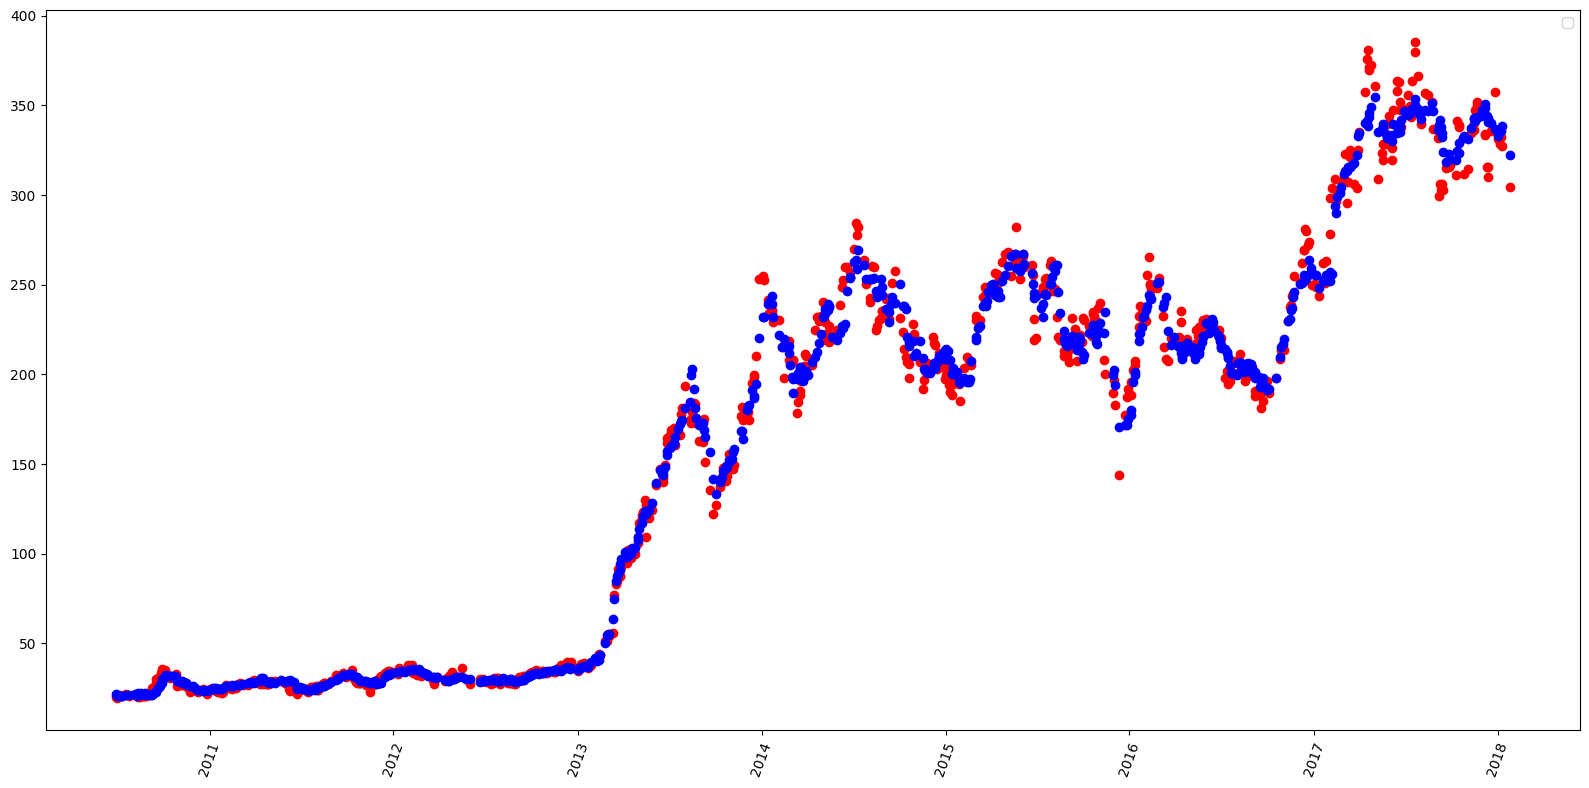

In [217]:
# Plot the time series data for y_pred and y_test
fig, ax = plt.subplots()
fig.subplots_adjust(bottom = 0.3)

fig.set_figwidth(16)
fig.set_figheight(8)

ax.plot(y_test.index, y_test['40d'], 'ro')
ax.plot(y_test.index, y_pred[:, 7], 'bo')

ax.legend()

plt.xticks(rotation = 70)
plt.tight_layout()
plt.show()

In [218]:
# Save the model for the future predictions
from joblib import dump
dump(regressor, 'rf_regressor.joblib')

['rf_regressor.joblib']